# 0. Initializations

In [1]:
# Import basic packages
import glob
import os
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# JQData API setup
from jqdatasdk import *

# Paid account info needed to get industry benchmark data
username = "XXX"
password = "***"
auth(username, password)

auth success 


In [3]:
# Data Collection Interval
START_DATE = '2016-01-01'
END_DATE = '2023-12-31'

# Index Benchmark is CSI 500
INDEX = '000905.XSHG' 

# For labelling purposes 
percent_select = [0.3, 0.3]

# train size setting in months (3 years)
train_size = 48

# 1. Load Data

In [4]:
trade_days_all = []
merged_df = pd.DataFrame()

folder_path = 'preprocess_000905.XSHG'  # Replace the path for testing different preprocessing methods
csv_files = glob.glob(f"{folder_path}/*.csv")

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.basename(file)
    filename_without_extension = os.path.splitext(filename)[0]
    
    # trade_days_all
    trade_days_all.append(filename_without_extension)

    # merged_df
    df['time'] = filename_without_extension
    merged_df = pd.concat([merged_df, df], ignore_index=True)

trade_days_all.sort()
merged_df.rename(columns={merged_df.columns[0]: 'code'}, inplace=True)


# check the date interval of data
print(len(trade_days_all), trade_days_all[0], trade_days_all[-1])


96 2016-01-29 2023-12-29


In [5]:
# trade days for test set
trade_days_test = trade_days_all[train_size:]

# 2. Train-Test Split

## 2.1 Calculate monthly return from closing price

In [6]:
price_df = pd.read_csv('stock_prices.csv')

merged_df_with_price = pd.merge(merged_df, price_df, on=['code', 'time'], how='inner') # inner join to remove rows with no price data
merged_df_with_price.drop(['circulating_market_cap', 'market_cap'], axis=1, inplace=True) # drop market cap data because the data are preprocessed at previous stage

# Create a new DataFrame for calculating monthly returns
df_monthly_returns = merged_df_with_price.copy()
df_monthly_returns['time'] = pd.to_datetime(df_monthly_returns['time']).dt.strftime('%Y-%m-%d')
df_monthly_returns.sort_values(by=['code', 'time'], inplace=True)

# Calculate the monthly return for each stock
df_monthly_returns['return'] = df_monthly_returns.groupby('code')['close'].pct_change()
df_monthly_returns['return'] = df_monthly_returns.groupby('code')['return'].shift(-1)

In [7]:
# Take a glimpse of a specific stock
df_monthly_returns[df_monthly_returns.code == '000006.XSHE'].head()

,code,pe_ratio,pb_ratio,ps_ratio,pcf_ratio,financial_leverage_ratio,debte_to_quity_ratio,cash_ratio,current_ratio,gross_profit_margin,...,BIAS,PSY,DIF,DEA,MACD,ATR14,HSL,time,close,return
10274,000006.XSHE,-0.097099,0.105552,-0.152594,-0.006966,-1.030405,-0.335289,0.881787,-0.411092,1.282566,...,-0.389633,-1.435175,-0.264364,-0.200889,-0.29501,0.552528,0.451993,2016-01-29,6.00,-0.013333
40629,000006.XSHE,-0.097099,0.105552,-0.152594,-0.006966,-1.030405,-0.335289,0.881787,-0.411092,1.282566,...,-0.389633,-1.435175,-0.264364,-0.200889,-0.29501,0.552528,0.451993,2016-02-29,5.92,0.130068
22416,000006.XSHE,-0.097099,0.105552,-0.152594,-0.006966,-1.030405,-0.335289,0.881787,-0.411092,1.282566,...,-0.389633,-1.435175,-0.264364,-0.200889,-0.29501,0.552528,0.451993,2016-03-31,6.69,-0.044843
30355,000006.XSHE,-0.097099,0.105552,-0.152594,-0.006966,-1.030405,-0.335289,0.881787,-0.411092,1.282566,...,-0.389633,-1.435175,-0.264364,-0.200889,-0.29501,0.552528,0.451993,2016-04-29,6.39,-0.068858
38761,000006.XSHE,-0.097099,0.105552,-0.152594,-0.006966,-1.030405,-0.335289,0.881787,-0.411092,1.282566,...,-0.389633,-1.435175,-0.264364,-0.200889,-0.29501,0.552528,0.451993,2016-05-31,5.95,0.015126


## 2.2 Label monthly return

In [8]:
# sort monthly stock return and label top 30% as 1, bottom 30% as 0 to distinguish between good and bad stocks

def label_data(data,dropna=True):
    data = data.copy()
    data.loc[:, 'return_bin'] = np.nan
    # sort decendingly by return and label according to percent_select
    data = data.sort_values(by='return', ascending=False)
    n_stock_select = np.multiply(percent_select, data.shape[0])
    n_stock_select = np.around(n_stock_select).astype(int)
    data.iloc[:n_stock_select[0], -1] = 1
    data.iloc[-n_stock_select[1]:, -1] = 0
    
    if dropna:
        data.drop('return',axis=1,inplace=True)
        data = data.dropna()
    return data

## 2.3 Construct train and test datasets

In [9]:
# training set is 3 years (2016-2018)

train_df_all = pd.DataFrame()
for date in trade_days_all[:train_size]:
    df = df_monthly_returns[df_monthly_returns['time'] == date]
    df = label_data(df)
    train_df_all = pd.concat([train_df_all,df])

train_df_all.drop(['code', 'time', 'close'], axis=1, inplace=True)

In [10]:
train_df_all.head()

,pe_ratio,pb_ratio,ps_ratio,pcf_ratio,financial_leverage_ratio,debte_to_quity_ratio,cash_ratio,current_ratio,gross_profit_margin,net_profit_margin,...,inc_net_profit_year_on_year,RSI,BIAS,PSY,DIF,DEA,MACD,ATR14,HSL,return_bin
10362,-0.079276,-1.413440,-0.466446,-0.207745,-0.609726,-0.354935,-0.031223,-0.656304,-1.413786,-0.064188,...,-0.052025,1.195600,1.120515,1.415836,1.891082,1.716884,1.492203,-1.193756,-0.178272,1.0
10326,-0.296463,-0.179423,-0.072646,0.034735,0.206037,-0.821873,-0.131484,0.963585,-0.118998,-0.075656,...,-0.061530,1.112760,0.757258,-0.580216,0.268617,0.320567,0.018871,0.048704,-0.142991,1.0
10421,-1.375815,-1.031885,-0.777321,-0.189121,-0.102293,-0.367180,-0.198121,3.244405,-1.164121,-0.141703,...,0.199561,0.778537,1.465620,-0.797400,0.417651,0.320445,0.449630,0.080336,-1.171924,1.0
10392,-0.564638,0.692921,3.051325,0.755527,-0.365439,0.322763,0.002599,-0.707351,-0.194761,0.252024,...,-0.164030,0.267977,1.199698,-0.437218,1.133318,0.629091,1.801394,-0.825519,-2.001563,1.0
10481,-0.492267,1.764361,0.181123,0.230191,0.516025,0.438969,0.007316,1.732601,0.767746,1.939921,...,0.356294,0.233273,0.835184,0.714793,0.982756,0.861248,0.814792,-0.812301,0.515203,1.0


In [11]:
# test set is 2019-2023

test_dict = {}
for date in trade_days_test[:-1]:
    df = df_monthly_returns[df_monthly_returns['time'] == date].copy()
    df.drop(['time', 'close'], axis=1, inplace=True)
    df.set_index('code', inplace=True)
    df = label_data(df,dropna=False)
    test_dict[date] = df

In [12]:
test_dict[trade_days_test[-2]].head()

,pe_ratio,pb_ratio,ps_ratio,pcf_ratio,financial_leverage_ratio,debte_to_quity_ratio,cash_ratio,current_ratio,gross_profit_margin,net_profit_margin,...,RSI,BIAS,PSY,DIF,DEA,MACD,ATR14,HSL,return,return_bin
code,,,,,,,,,,,,,,,,,,,,,
000762.XSHE,-1.553677,0.725229,1.232851,-0.088776,-0.815578,-0.871437,0.066250,-1.422533,-0.165614,-0.266925,...,0.561652,0.171987,-0.737436,-1.887860,-1.999036,-0.785849,2.287849,3.699024,0.236489,1.0
002238.XSHE,-0.180199,-0.313289,-0.282526,0.334274,-0.125660,-0.110913,0.015630,-0.542511,0.369962,0.439808,...,0.524443,-0.197801,0.217076,0.503521,0.332188,0.719530,-0.823790,0.235189,0.235481,1.0
002022.XSHE,-0.019140,0.607222,0.598648,-0.049419,-0.607436,-0.319762,-0.012787,-1.313594,0.081802,0.786419,...,0.026504,0.131409,-0.388402,-1.469829,-1.863461,0.234531,0.817342,0.251882,0.232936,1.0
601226.XSHG,0.256034,0.270165,0.010501,-4.376852,-0.714141,-1.079959,0.585489,-0.259085,0.035491,-0.013321,...,-0.778165,0.003974,0.832852,-0.188781,-0.204454,-0.069833,0.086739,-0.236078,0.172906,1.0
000620.XSHE,0.001974,-0.042075,-0.107739,0.046960,0.937460,2.056678,0.808407,-0.318948,-0.461376,-0.332672,...,-1.056949,0.140154,-0.962348,-0.168110,-0.285408,0.197781,-0.089650,-0.824287,0.145455,1.0


# 3. Pre-training

## 3.1 Seperate features and labels

In [13]:
# Extract features
X = train_df_all.iloc[:,:-1]
# Extract labels
y = train_df_all['return_bin']

## 3.2 Automatic feature selection based on feature importance

In [14]:
# Embedded Method using random forest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
RFC_ = RFC(n_estimators =100,max_depth=2,random_state=0)

# Brief overview of feature importance
result = RFC_.fit(X,y).feature_importances_
result


array([0.07049847, 0.05853837, 0.07949022, 0.00842827, 0.01489435,
       0.03071117, 0.04128363, 0.03469902, 0.04990591, 0.06262186,
       0.02659015, 0.03000306, 0.05411936, 0.00873488, 0.00908138,
       0.00983498, 0.02557405, 0.01631028, 0.07157251, 0.09052327,
       0.05507287, 0.02522394, 0.12628798])

In [15]:
# select features with importance > 0.05
selector = SelectFromModel(RFC_,threshold=0.05).fit(X,y)
X_embedded = selector.transform(X)
X_embedded.shape

(13417, 9)

# 4. Training and Evaluation

## 4.0 Model training

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve,f1_score
import matplotlib.dates as mdates

# Plot F1 score trend
def plot_f1_score(f1_list, trade_days_test):
    print("avg F1 Score:", np.mean(f1_list))
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    # Convert string dates to datetime objects and create a locator for months
    dates = [pd.to_datetime(d) for d in trade_days_test[:-1]]
    locator = mdates.MonthLocator(interval=6)  # Shows every month
    formatter = mdates.DateFormatter('%Y-%m')  # Format the date to show year and month only
    plt.plot(dates, f1_list, label='F1 Score')
    # Set major locator and formatter
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xlim(min(dates), max(dates))
    plt.xticks(rotation=0) 
    plt.xlabel('Test Date')
    plt.grid(axis='x')
    plt.legend(fontsize='large')
    plt.ylim(bottom=0, top=1)
    plt.show()

### 4.0.1 Naive Bayes

In [17]:
# GaussianNB for initial testing
from sklearn.naive_bayes import GaussianNB
bys = GaussianNB()

print('cross_val_score : ')
accuracy_train = cross_val_score(bys,X_embedded,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))
auc_train = cross_val_score(bys,X_embedded,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))

cross_val_score : 
	 accuracy = 0.5123
	 auc = 0.5285


In [18]:
bys.fit(X_embedded,y)

GaussianNB()

### 4.0.2 XGBoost

In [19]:
from xgboost import XGBClassifier

# Define model
xgb = XGBClassifier()

# Define parameter grid
param_grid = {
    'n_estimators': [10, 15, 20],
    'max_depth': [1, 2], # 2
    'learning_rate': [0.15, 0.2]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=5, verbose=1)

# Fit model
grid_search.fit(X_embedded, y) # n_estimators=10,max_depth=2, learning_rate=0.15

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best average F1 found: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 10}
Best average F1 found:  0.5508965589396124


In [20]:
xgb = XGBClassifier(n_estimators=10,max_depth=1, learning_rate=0.2)
xgb.fit(X_embedded, y) # n_estimators=10,max_depth=1, learning_rate=0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 4.1 Evaluation With 5 groups of quantiles

### 4.1.0 Define standard functions for training, plotting and evaluation

In [21]:
# Divide into 5 quantiles based on confidence of prediction that the stock is good performing stock
def group_return(df): 
    length = df.shape[0]//5
    df = df.sort_values('predict', ascending=False)    
    g1 = df.iloc[:length,:]['return'].mean()
    g2 = df.iloc[length:2*length,:]['return'].mean()
    g3 = df.iloc[2*length:-2*length,:]['return'].mean()
    g4 = df.iloc[-2*length:-length,:]['return'].mean()
    g5 = df.iloc[-length:,:]['return'].mean()
    return [g1,g2,g3,g4,g5]


# Evaluate model performance
def model_evaluation(model, test_dict, trade_days_test, selector):
    """
    Parameters:
        model: Trained model.
        test_dict: Dictionary of test datasets.
        trade_days_test: List of test dates.
        selector: Feature selector.
    Returns:
        accuracy_monthly: List of monthly accuracy scores.
        auc_monthly: List of monthly AUC scores.
        f1_score_monthly: List of monthly F1 scores.
        group_df: DataFrame of monthly returns for each group.
    """
    accuracy_monthly = []
    auc_monthly = []
    f1_score_monthly = []
    group_return_dict = {}
    # Iterate through test dates
    for idx, date in enumerate(trade_days_test[:-1]):
        # Get current test dataset
        df = test_dict[date].copy()
        # Predict probabilities
        if hasattr(model, 'decision_function'):
            y_predict = model.decision_function(selector.transform(df.iloc[:, :-2]))
        else:
            y_predict = model.predict_proba(selector.transform(df.iloc[:, :-2]))[:, 1]
        x_test = selector.transform(df[df['return_bin'].notnull()].iloc[:, :-2])
        y_test = df[df['return_bin'].notnull()].iloc[:, -1]
        # Calculate accuracy for current period
        accuracy_monthly.append(model.score(x_test, y_test))
        # Calculate AUC for current period
        auc_monthly.append(roc_auc_score(y_test, y_predict[df['return_bin'].notnull()]))
        # Calculate F1 score
        y_pred_class = model.predict(x_test)
        f1_monthly = f1_score(y_test, y_pred_class)
        f1_score_monthly.append(f1_monthly)
        # Segment stocks into 5 groups based on predictions and calculate returns
        df['predict'] = y_predict
        grouplist = group_return(df)
        # Calculate next period's benchmark return
        bench = get_price(INDEX, date, trade_days_test[idx + 1], fields=['close'], panel=False)['close'] # use JQData API to retrieve benchmark price data
        bench_return = (bench[-1] - bench[0]) / bench[0]
        grouplist.append(bench_return)
        group_return_dict[date] = grouplist
    group_df = pd.DataFrame(group_return_dict, index=['group1', 'group2', 'group3', 'group4', 'group5', 'benchmark']).T
    return accuracy_monthly, auc_monthly, f1_score_monthly, group_df


# Backtesting and benchmark comparison of 5 groups
def visualization(result_df):
    # Cumulative Return Calculation
    Result_cum_return = (result_df + 1).cumprod()
    Result_cum_return.index = pd.to_datetime(Result_cum_return.index) 
    plt.figure(figsize=(10,6))
    plt.style.use('ggplot')
    plt.plot(Result_cum_return['group1'], label="group1", linewidth=2)
    plt.plot(Result_cum_return['group2'], label="group2", linewidth=2)
    plt.plot(Result_cum_return['group3'], label="group3", linewidth=2)
    plt.plot(Result_cum_return['group4'], label="group4", linewidth=2)
    plt.plot(Result_cum_return['group5'], label="group5", linewidth=2)
    plt.plot(Result_cum_return['benchmark'], ls='--', label="benchmark", linewidth=2)    
    # Define the date format and locator for x-axis ticks
    locator = mdates.MonthLocator(interval=6)  # Every six months
    formatter = mdates.DateFormatter('%Y-%m')
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)    
    # Rotate and set font size for x-ticks
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Test Date')
    plt.ylabel('Portfolio Value')
    plt.grid(axis='x')
    # Set the legend to the left side with a larger font size
    plt.legend(fontsize='large', loc='upper left')
    # Set the x-axis limits to include the first and last month
    first_date = Result_cum_return.index.min()
    last_date = Result_cum_return.index.max()
    plt.gca().set_xlim(first_date - pd.offsets.MonthBegin(), last_date + pd.offsets.MonthEnd())
    plt.show()


# Summary of full evaluation matrix
def evaluation(group_df):
    index = ['Cumulative Return','Annualized Return','Maximum Drawdown','Sharpe Ratio','Annualized Excess Return',
             'Monthly Maximum Excess Return','Proportion of Months Beating the Benchmark','Proportion of Positive Return Months',
             'Information Ratio']
    eval_df = pd.DataFrame(np.zeros((9,6)),index=index,columns=['G1','G2','G3','G4','G5','Benchmark'])
    ret_bc = group_df.iloc[:,-1]
    for i in range(len(group_df.columns)):
        ret = group_df.iloc[:,i]
        n = len(group_df.index)
        # Cumulative Return
        return_cump = np.around((ret+1).cumprod()[-1] * 100, 1)
        eval_df.iloc[0, i] = str(np.around(return_cump-100,1)) + '%'
        # Annualized Return
        annul = (return_cump / 100) ** (12 / n) - 1
        eval_df.iloc[1, i] = str(np.round(annul * 100, 2)) + '%'
        # Maximum Drawdown
        cummax = (group_df + 1).cumprod().iloc[:, i].cummax()
        maxback = ((cummax - (group_df + 1).cumprod().iloc[:, i]) / cummax).max()
        eval_df.iloc[2, i] = str(np.around(maxback*100, 2)) + '%'
        # Sharpe Ratio
        eval_df.iloc[3, i] = np.around((annul - 0.04) / ret.std(), 2)
        # Annualized Excess Return
        alpha = (ret - ret_bc + 1).cumprod()[-1]
        alpha_ann = (alpha) ** (12 / n) - 1
        eval_df.iloc[4, i] = str(np.round(alpha_ann * 100, 2)) + '%'
        # Monthly Maximum Excess Return
        eval_df.iloc[5, i] = str(np.round((ret - ret_bc).max() * 100, 2)) + '%'
        # Proportion of Months Beating the Benchmark
        eval_df.iloc[6, i] = str(np.round((ret > ret_bc).sum() / n * 100, 2)) + '%'
        # Proportion of Positive Return Months
        eval_df.iloc[7, i] = str(np.round((ret > 0).sum() / n * 100, 2)) + '%'
        # Information Ratio
        ann_bc = (ret_bc+1).cumprod()[-1]**(12/n)-1
        std = (ret-ret_bc).std()
        eval_df.iloc[8, i] = np.around((annul - ann_bc)/std,2) if i!=len(group_df.columns)-1 else np.NAN
    return eval_df


### 4.1.1 Naive Bayes

avg F1 Score: 0.5913094869718369


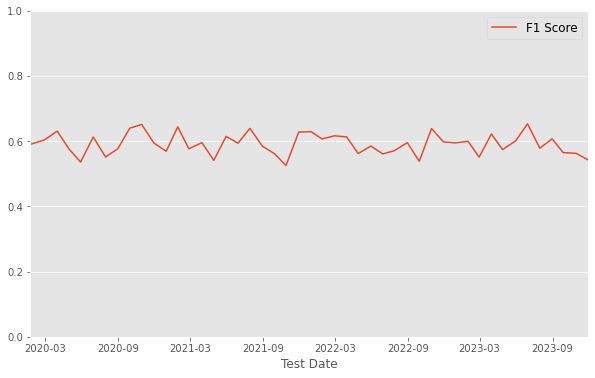

In [22]:
accu_nb5, auc_nb5, f1_score_nb5, group_df_nb5 = model_evaluation(bys,test_dict,trade_days_test,selector)
plot_f1_score(f1_score_nb5,trade_days_test)

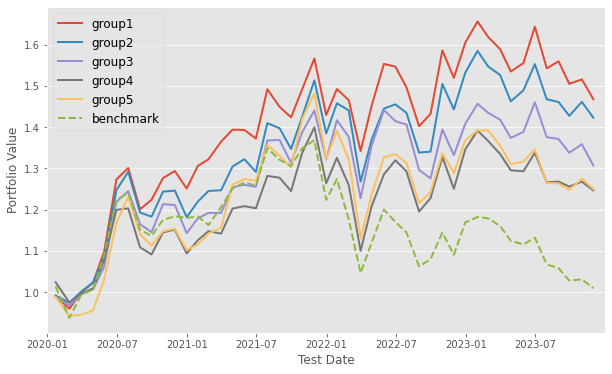

In [23]:
# Backtesting and benchmark comparison
visualization(group_df_nb5)

In [24]:
# Evaluate overall return performance
evaluation(group_df_nb5)

,G1,G2,G3,G4,G5,Benchmark
Cumulative Return,46.8%,42.3%,30.7%,24.7%,25.0%,1.0%
Annualized Return,10.3%,9.42%,7.07%,5.8%,5.86%,0.25%
Maximum Drawdown,14.33%,16.21%,14.75%,21.39%,23.75%,26.23%
Sharpe Ratio,1.23,1.03,0.59,0.35,0.34,-0.75
Annualized Excess Return,9.81%,8.93%,6.6%,5.4%,5.63%,0.0%
Monthly Maximum Excess Return,5.9%,6.53%,5.36%,5.15%,5.7%,0.0%
Proportion of Months Beating the Benchmark,57.45%,65.96%,63.83%,61.7%,59.57%,0.0%
Proportion of Positive Return Months,55.32%,55.32%,51.06%,55.32%,55.32%,51.06%
Information Ratio,4.82,3.68,2.93,2.74,2.57,NaN


### 4.1.2 XGBoost

avg F1 Score: 0.5443178293823442


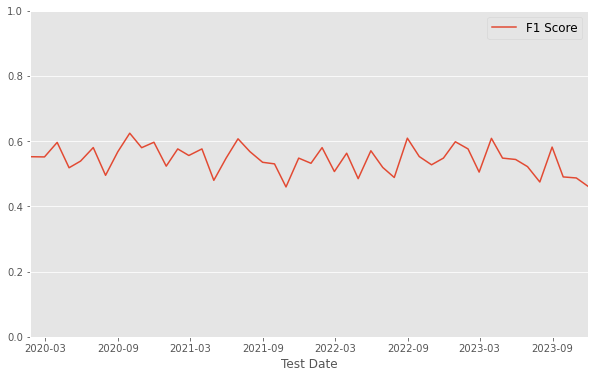

In [25]:
accu_xgb5, auc_xgb5, f1_score_xgb5, group_df_xgb5 = model_evaluation(xgb,test_dict,trade_days_test,selector)
plot_f1_score(f1_score_xgb5,trade_days_test)

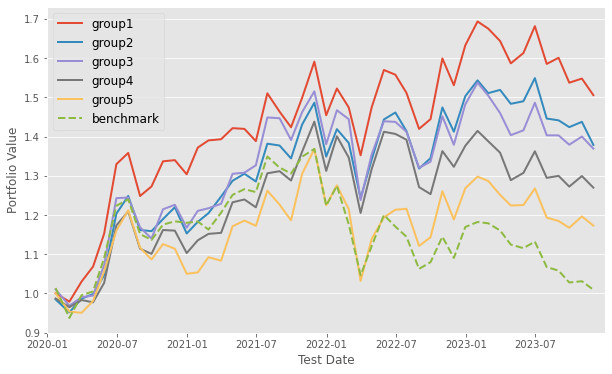

In [26]:
# Backtesting and benchmark comparison
visualization(group_df_xgb5)

In [27]:
# Evaluate overall return performance
evaluation(group_df_xgb5)

,G1,G2,G3,G4,G5,Benchmark
Cumulative Return,50.6%,37.9%,36.9%,27.0%,17.3%,1.0%
Annualized Return,11.02%,8.55%,8.35%,6.29%,4.16%,0.25%
Maximum Drawdown,15.0%,16.39%,18.29%,16.2%,24.58%,26.23%
Sharpe Ratio,1.36,0.91,0.8,0.45,0.03,-0.75
Annualized Excess Return,10.55%,8.02%,8.1%,5.74%,3.87%,0.0%
Monthly Maximum Excess Return,5.37%,5.22%,6.15%,5.28%,6.73%,0.0%
Proportion of Months Beating the Benchmark,57.45%,70.21%,61.7%,59.57%,55.32%,0.0%
Proportion of Positive Return Months,57.45%,57.45%,57.45%,51.06%,53.19%,51.06%
Information Ratio,5.04,4.0,3.71,2.56,1.46,NaN


## 4.2 Evaluation With 2 groups of quantiles

### 4.2.0 Define standard functions for training, plotting and evaluation

In [28]:
# Divide into 2 quantiles: Top 50% and Bottom 50%
def group_return(df): 
    length = df.shape[0] // 2
    df = df.sort_values('predict', ascending=False)    
    g1 = df.iloc[:length]['return'].mean()  # Top 50%
    g2 = df.iloc[length:]['return'].mean()  # Bottom 50%
    return [g1, g2]

# Evaluate model performance
def model_evaluation(model, test_dict, trade_days_test, selector):
    accuracy_monthly = []
    auc_monthly = []
    f1_score_monthly = []
    group_return_dict = {}
    for idx, date in enumerate(trade_days_test[:-1]):
        df = test_dict[date].copy()
        if hasattr(model, 'decision_function'):
            y_predict = model.decision_function(selector.transform(df.iloc[:,:-2]))
        else:
            y_predict = model.predict_proba(selector.transform(df.iloc[:,:-2]))[:,1]
        x_test = selector.transform(df[df['return_bin'].notnull()].iloc[:,:-2])
        y_test = df[df['return_bin'].notnull()].iloc[:,-1]
        accuracy_monthly.append(model.score(x_test, y_test))
        auc_monthly.append(roc_auc_score(y_test, y_predict[df['return_bin'].notnull()]))
        y_pred_class = model.predict(x_test)
        f1_monthly = f1_score(y_test, y_pred_class)
        f1_score_monthly.append(f1_monthly)
        df['predict'] = y_predict
        grouplist = group_return(df)
        bench = get_price(INDEX, date, trade_days_test[idx+1], fields=['close'], panel=False)['close']
        bench = (bench[-1] - bench[0]) / bench[0]
        grouplist.append(bench)
        group_return_dict[date] = grouplist
    group_df = pd.DataFrame(group_return_dict, index=['group1', 'group2', 'benchmark']).T
    return accuracy_monthly, auc_monthly, f1_score_monthly, group_df


# Backtesting and benchmark comparison of 2 groups
def visualization(result_df):
    # Calculate cumulative returns
    Result_cum_return = (result_df + 1).cumprod()
    Result_cum_return.index = pd.to_datetime(Result_cum_return.index)  
    # Create figure
    plt.figure(figsize=(10,6))
    # Define plot style
    plt.style.use('ggplot')    
    # Plotting with increased line width and updated group labels
    plt.plot(Result_cum_return['group1'], label="Top 50%", linewidth=2)
    plt.plot(Result_cum_return['group2'], label="Bottom 50%", linewidth=2)
    plt.plot(Result_cum_return['benchmark'], ls='--', label="Benchmark", linewidth=2)    
    # Define the date format and locator for x-axis ticks
    locator = mdates.MonthLocator(interval=6)  # Every six months
    formatter = mdates.DateFormatter('%Y-%m')
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)    
    # Rotate and set font size for x-ticks
    plt.xticks(rotation=0, fontsize=10)  # Changed rotation to 0 for horizontal labels
    plt.yticks(fontsize=10)
    plt.xlabel('Test Date')
    plt.ylabel('Portfolio Value')  # Added y-axis label    
    # Set the legend to the upper left side with a larger font size
    plt.legend(fontsize='large', loc='upper left')
    # Adjust the x-axis limits to include the first and last month without cutting them off
    first_date = Result_cum_return.index.min()
    last_date = Result_cum_return.index.max()
    plt.gca().set_xlim(first_date - pd.offsets.MonthBegin(), last_date + pd.offsets.MonthEnd())
    plt.show()
    

# Summary of full evaluation matrix
def evaluation(group_df):
    index = ['Cumulative Return','Annualized Return','Maximum Drawdown','Sharpe Ratio','Annualized Excess Return',
             'Monthly Maximum Excess Return','Proportion of Months Beating the Benchmark','Proportion of Positive Return Months',
             'Information Ratio']
    eval_df = pd.DataFrame(np.zeros((9, 3)), index=index, columns=['Top 50%', 'Bottom 50%', 'benchmark'])
    ret_bc = group_df.iloc[:,-1]
    for i in range(len(group_df.columns)):
        ret = group_df.iloc[:,i]
        n = len(group_df.index)
        # Cumulative Return
        return_cump = np.around((ret+1).cumprod()[-1] * 100, 1)
        eval_df.iloc[0, i] = str(np.around(return_cump-100,1)) + '%'
        # Annualized Return
        annul = (return_cump / 100) ** (12 / n) - 1
        eval_df.iloc[1, i] = str(np.round(annul * 100, 2)) + '%'
        # Maximum Drawdown
        cummax = (group_df + 1).cumprod().iloc[:, i].cummax()
        maxback = ((cummax - (group_df + 1).cumprod().iloc[:, i]) / cummax).max()
        eval_df.iloc[2, i] = str(np.around(maxback*100, 2)) + '%'
        # Sharpe Ratio
        eval_df.iloc[3, i] = np.around((annul - 0.04) / ret.std(), 2)
        # Annualized Excess Return
        alpha = (ret - ret_bc + 1).cumprod()[-1]
        alpha_ann = (alpha) ** (12 / n) - 1
        eval_df.iloc[4, i] = str(np.round(alpha_ann * 100, 2)) + '%'
        # Monthly Maximum Excess Return
        eval_df.iloc[5, i] = str(np.round((ret - ret_bc).max() * 100, 2)) + '%'
        # Proportion of Months Beating the Benchmark
        eval_df.iloc[6, i] = str(np.round((ret > ret_bc).sum() / n * 100, 2)) + '%'
        # Proportion of Positive Return Months
        eval_df.iloc[7, i] = str(np.round((ret > 0).sum() / n * 100, 2)) + '%'
        # Information Ratio
        ann_bc = (ret_bc+1).cumprod()[-1]**(12/n)-1
        std = (ret-ret_bc).std()
        eval_df.iloc[8, i] = np.around((annul - ann_bc)/std,2) if i!=len(group_df.columns)-1 else np.NAN
    return eval_df
    

### 4.2.1 Naive Bayes

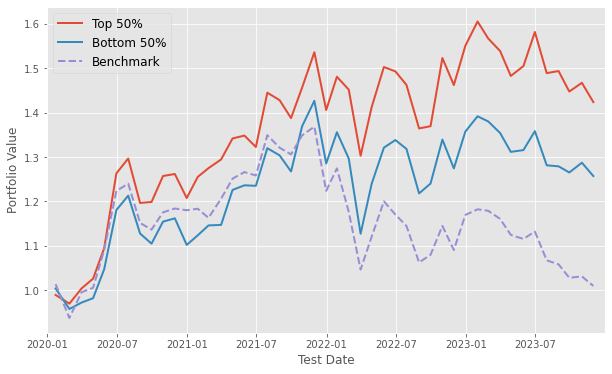

In [29]:
# Backtesting and benchmark comparison
accu_nb2, auc_nb2, f1_score_nb2, group_df_nb2 = model_evaluation(bys,test_dict,trade_days_test,selector)
visualization(group_df_nb2)

In [30]:
# Evaluate overall return performance
evaluation(group_df_nb2)

,Top 50%,Bottom 50%,benchmark
Cumulative Return,42.4%,25.7%,1.0%
Annualized Return,9.44%,6.01%,0.25%
Maximum Drawdown,15.18%,20.99%,26.23%
Sharpe Ratio,1.05,0.39,-0.75
Annualized Excess Return,8.97%,5.65%,0.0%
Monthly Maximum Excess Return,5.75%,4.76%,0.0%
Proportion of Months Beating the Benchmark,57.45%,59.57%,0.0%
Proportion of Positive Return Months,57.45%,57.45%,51.06%
Information Ratio,4.19,2.89,NaN


### 4.2.2 XGBoost

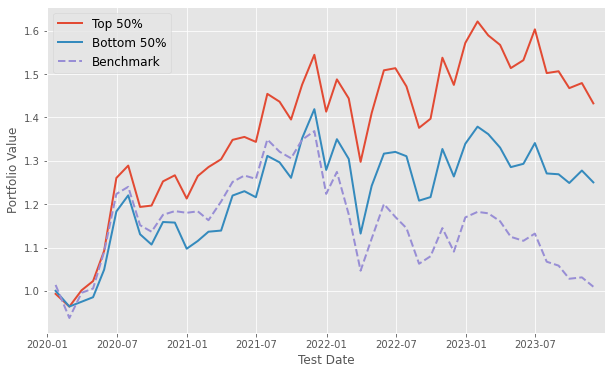

In [31]:
# Backtesting and benchmark comparison
accu_xgb2, auc_xgb2, f1_score_xgb2, group_df_xgb2 = model_evaluation(xgb,test_dict,trade_days_test,selector)
visualization(group_df_xgb2)

In [32]:
# Evaluate overall return performance
evaluation(group_df_xgb2)

,Top 50%,Bottom 50%,benchmark
Cumulative Return,43.2%,25.0%,1.0%
Annualized Return,9.6%,5.86%,0.25%
Maximum Drawdown,15.99%,20.22%,26.23%
Sharpe Ratio,1.1,0.36,-0.75
Annualized Excess Return,9.17%,5.49%,0.0%
Monthly Maximum Excess Return,4.75%,4.33%,0.0%
Proportion of Months Beating the Benchmark,61.7%,55.32%,0.0%
Proportion of Positive Return Months,59.57%,55.32%,51.06%
Information Ratio,4.8,2.62,NaN
